In [1]:
import pickle
from functools import partial
from os import listdir
from os.path import isfile, join

import numpy as np
import scipy
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

from common import CityResult
from file_name_generator import generate_new_name


Загрузка данных

In [2]:
mypath = './clusters_results/few_city'

In [3]:
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

r : dict[str:CityResult]= {}
for name in onlyfiles:
    with open(join(mypath, name), 'rb') as f:
        r[name] = pickle.load(f)
        f.close()

Обработка данных

In [4]:
def theory_func(x,c, g, N = 9574, b0 = 1):
    x = x * c
    q = np.log(x) / np.log(N)
    return g / (x / b0 * (1 + q) + c / (np.sqrt(x * N)) * (1 - q))

In [5]:
X_a = {}
Y_err = {}
Y_err_std = {}

Y_speedup = {}

for name in r:
    result: CityResult = r[name]
    X_a[name] = [a.alpha for a in result.points_results]
    Y_err[name] = [np.mean(a.errors) for a in result.points_results]
    Y_err_std[name] = [np.std(a.errors) for a in result.points_results]
    Y_speedup[name] = [np.mean(a.speed_up) for a in result.points_results]

Графики:

729 1.4650205761316872
729 0.00402478180255958
8924 1.562752129090094
8924 0.00035027504854647407
28063 1.4989487937854113
28063 0.00010683121614891393
58334 1.448023451160558
58334 4.9646802021516405e-05
5467 1.3938174501554783
5467 0.0005099954080334718
3347 1.3495667762175083
3347 0.0008066747018634239
49487 1.4571907773758765
49487 5.8893051666163217e-05
17742 1.5092436027505354
17742 0.00017014188633679447
9574 1.5599540421976186
9574 0.00032590703900503885
21637 1.3896103896103895
21637 0.0001284535394352366
70887 1.3768533017337452
70887 3.8846974063531454e-05
43508 1.3916521099567896
43508 6.397371043541451e-05
22336 1.4789577363896849
22336 0.00013243409325181866
23860 1.4896060352053646
23860 0.00012486743243265557


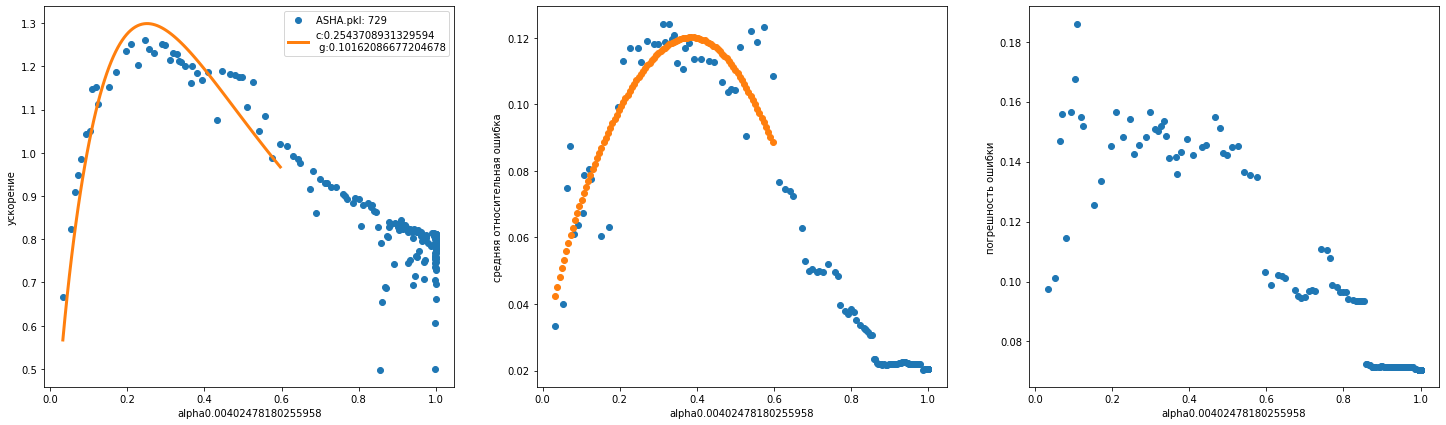

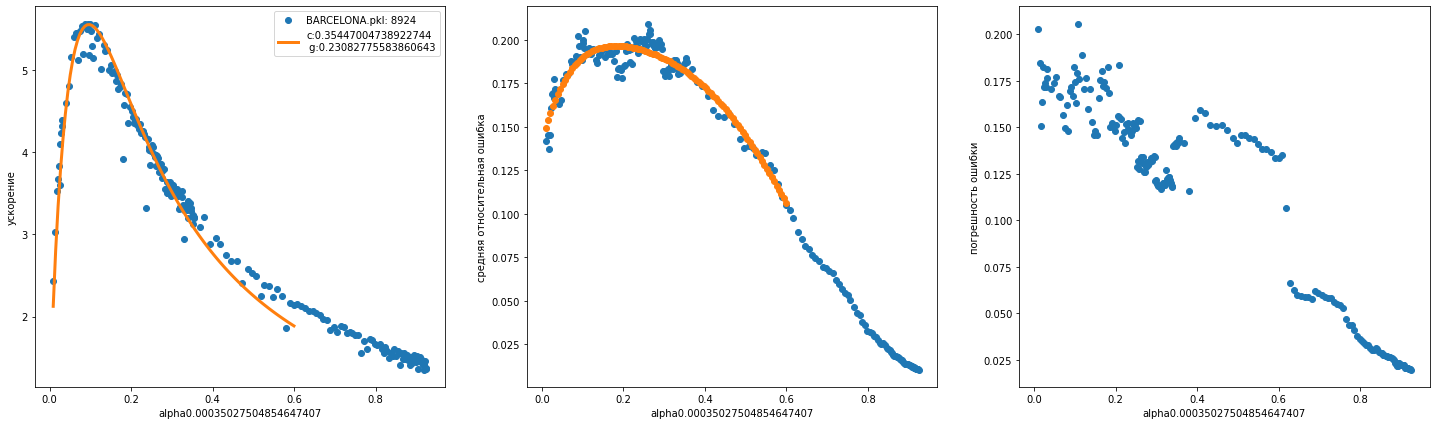

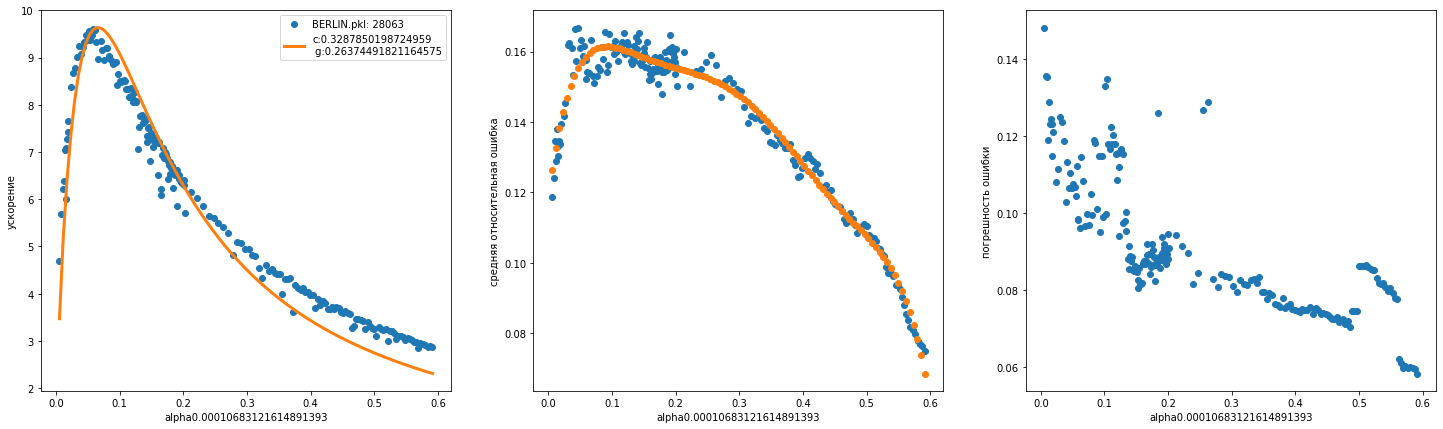

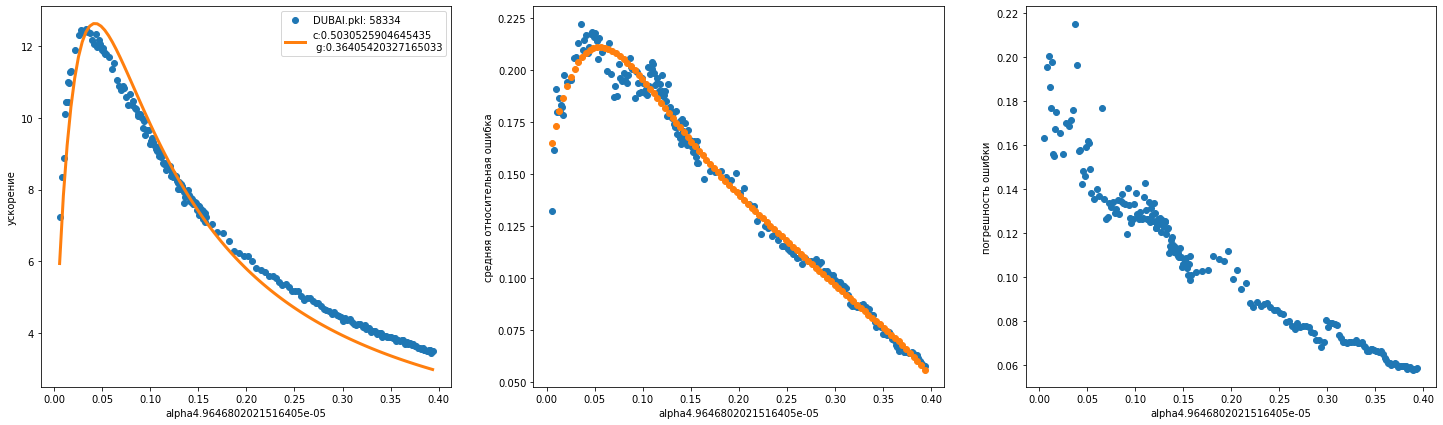

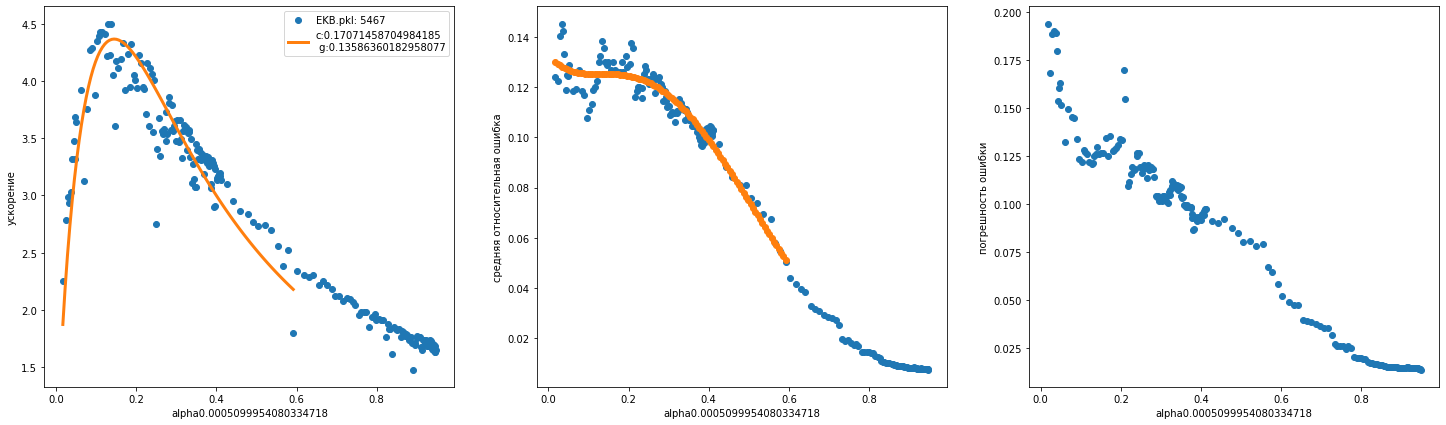

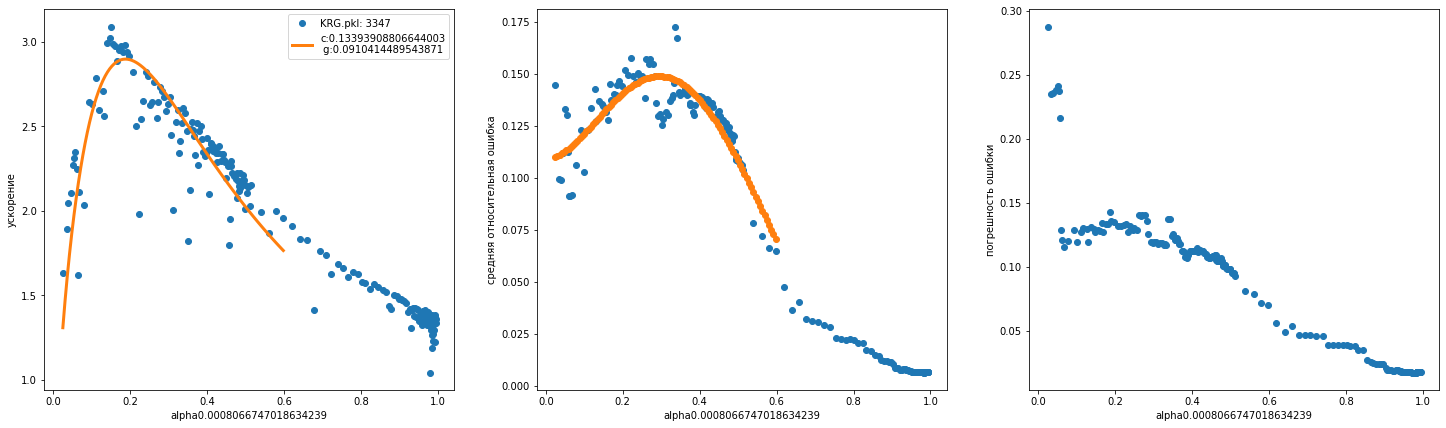

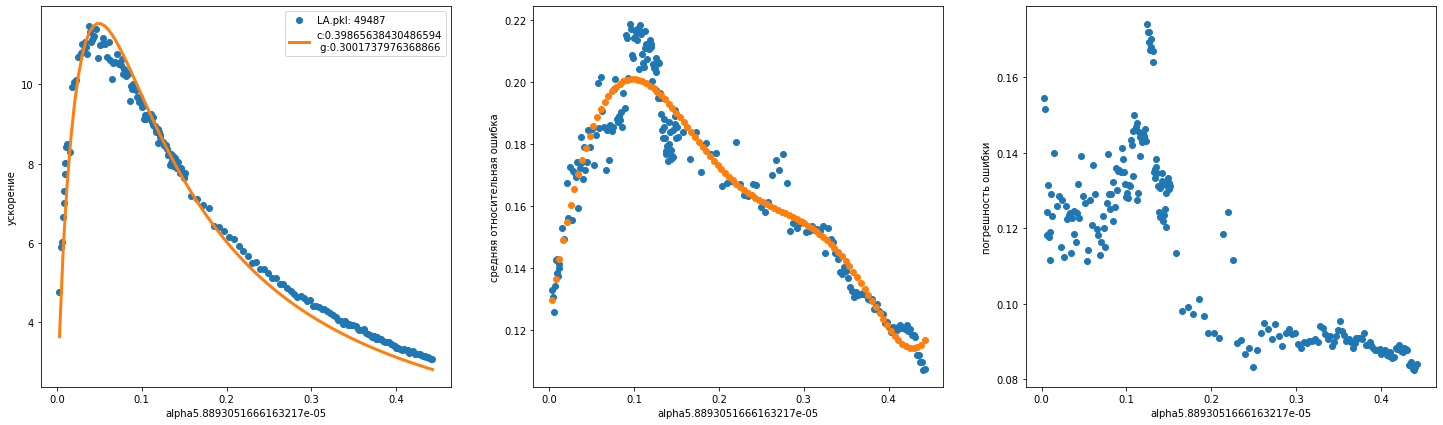

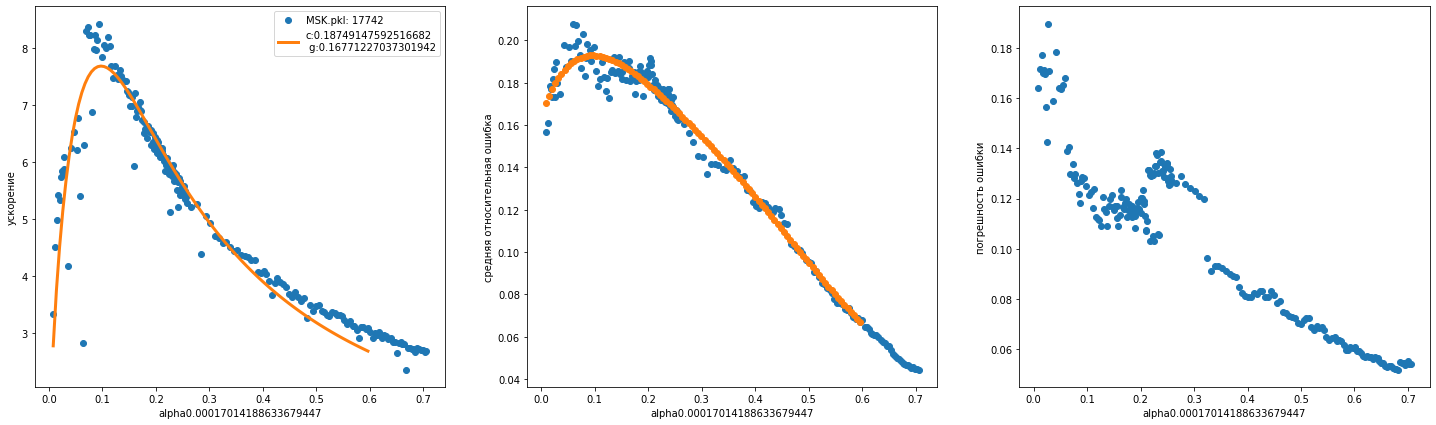

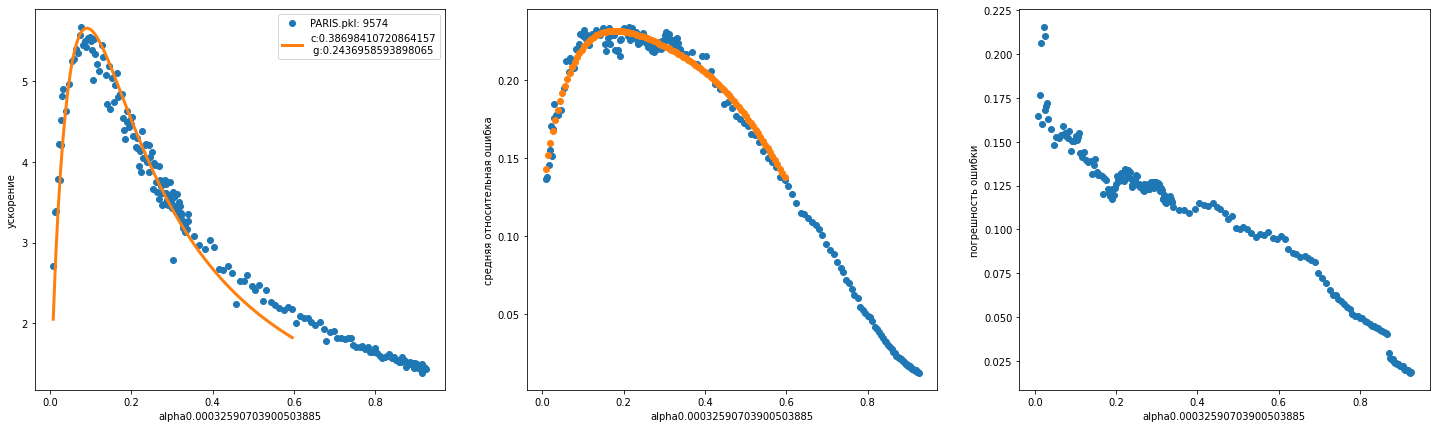

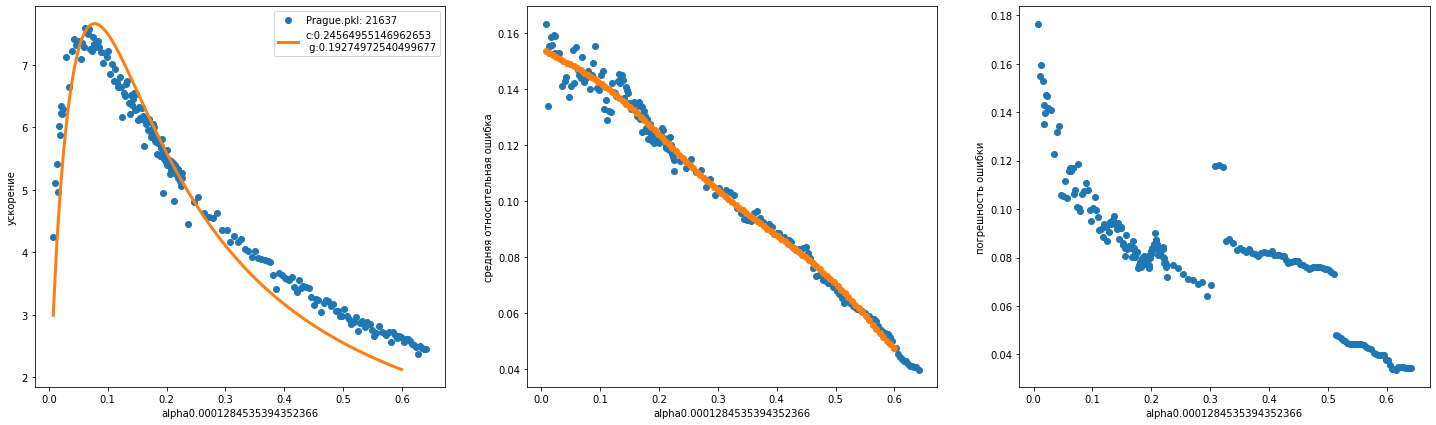

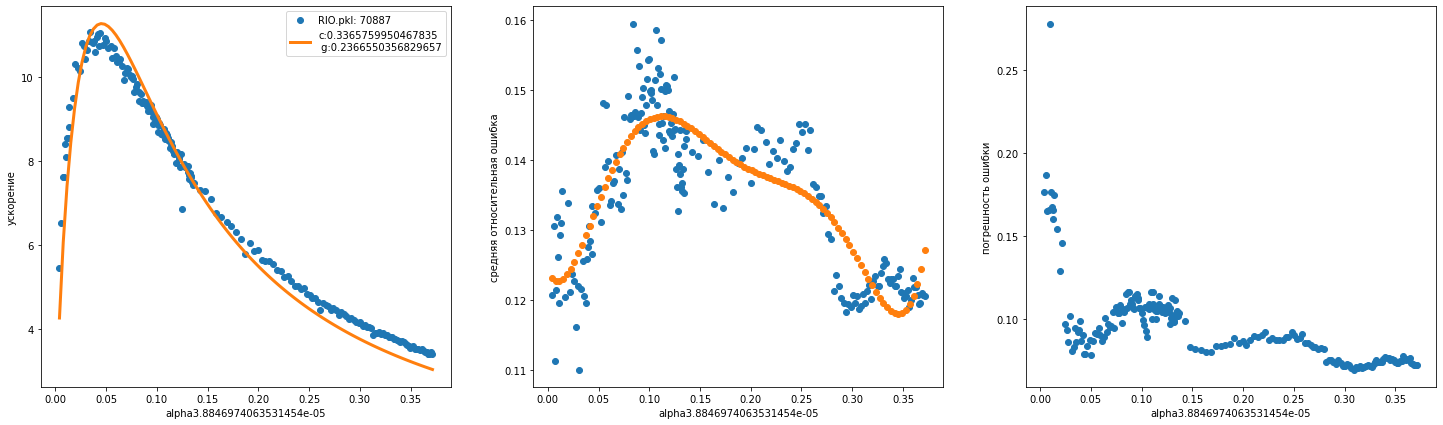

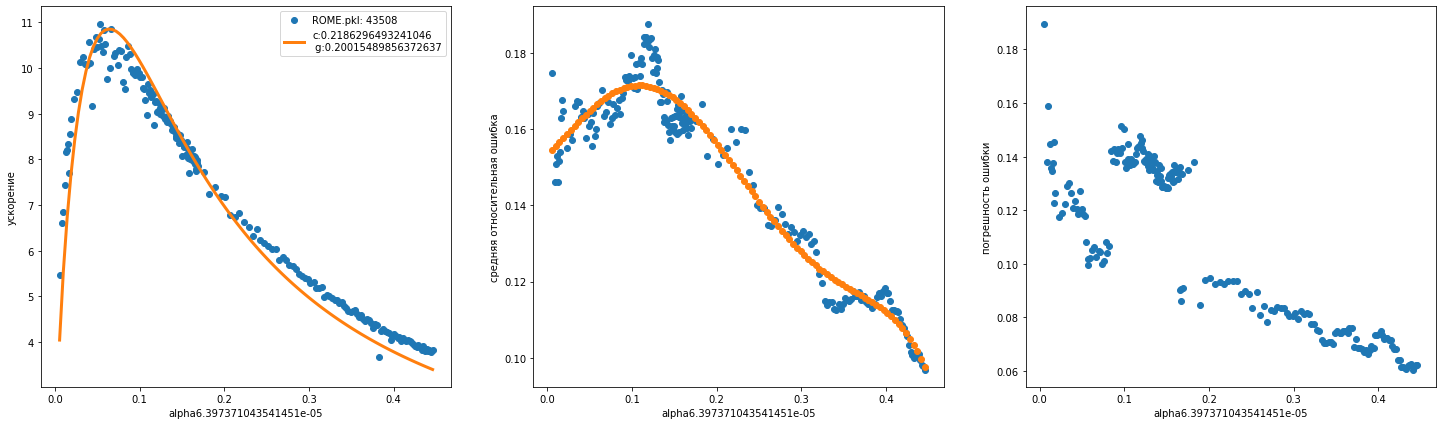

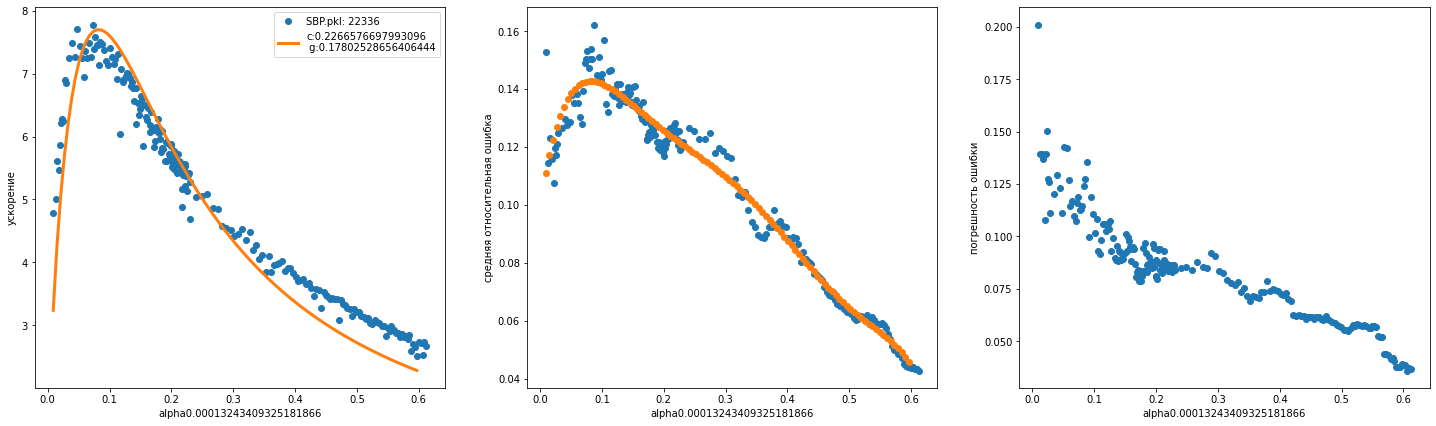

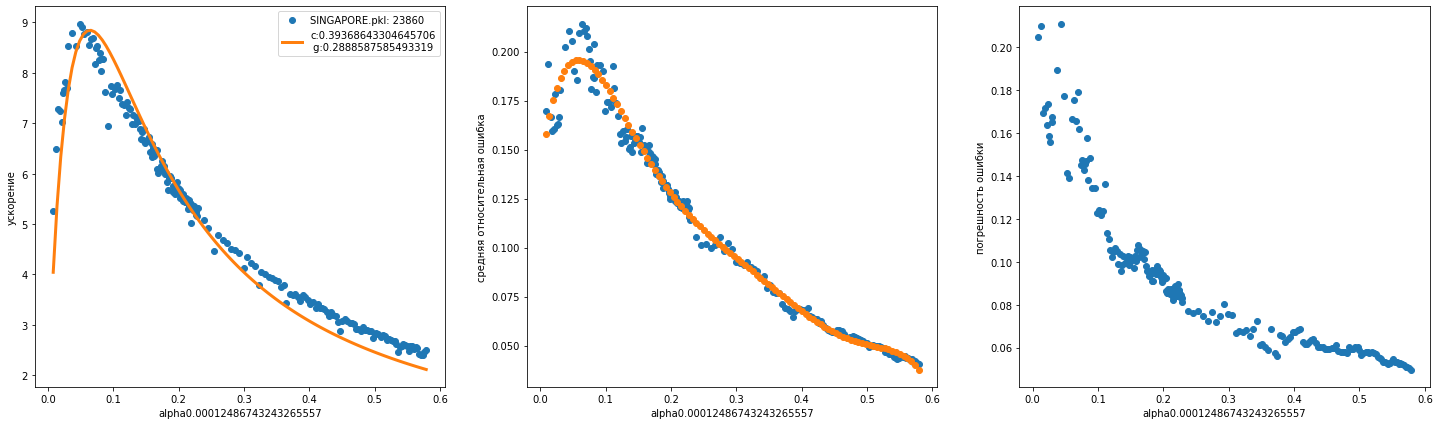

In [22]:
city_to_n = {}
X_max = {}
Y_speedup_max = {}
Y_err_speedup = {}

c = {}
b = {}
for name in r:
    fig, axs = plt.subplots(1, 3)
    fig.set_figwidth(25)
    fig.set_figheight(7)

    axs[0].errorbar(X_a[name], Y_speedup[name], fmt='o', label = "{}: {}".format(name, r[name].nodes))
    axs[0].set(xlabel='alpha'+ str(r[name].density), ylabel='ускорение')

    func_r = partial(theory_func, N=r[name].nodes, b0=r[name].edges/r[name].nodes)
    print(str(r[name].nodes) + ' ' + str(r[name].edges/r[name].nodes))
    print(str(r[name].nodes) + ' ' + str(2*r[name].edges/(r[name].nodes * (r[name].nodes-1))))

    _x = np.array(X_a[name])
    _x = _x[_x < 0.6]
    _xx = np.linspace(min(_x), max(_x), 100)


    _y = np.array(Y_speedup[name])[0:len(_x)]
    popt = curve_fit(func_r, _x, _y, p0=[0.0003, 4],bounds=(0,[10,1000]))
    # if 'ASHA' in name:
    #     func_target = partial(theory_func, c=0.00005, g=25,N=r[name].nodes, b0=r[name].density)
    # else:
    func_target = partial(theory_func, c=popt[0][0], g=popt[0][1],N=r[name].nodes, b0=r[name].edges/r[name].nodes)
    a = scipy.optimize.fminbound(lambda x: -func_target(x), 0, 0.5)
    city_to_n[name] = r[name].nodes
    X_max[name] = a
    Y_speedup_max[name] = func_target(a)

    c[name] = popt[0][0]
    b[name] = popt[0][1]

    _y = func_target(np.array(_xx))
    axs[0].errorbar(_xx, _y, linewidth=3, label = "c:{}\n g:{}".format(popt[0][0],popt[0][1]))
    axs[0].legend()
    axs[1].errorbar(X_a[name], Y_err[name], fmt='o')
    axs[1].set(xlabel='alpha' + str(r[name].density), ylabel='средняя относительная ошибка')
    z = np.polyfit(X_a[name], Y_err[name], 6)
    p = np.poly1d(z)
    axs[1].errorbar(_xx, p(_xx), fmt='o')
    Y_err_speedup[name] = p(a)



    axs[2].errorbar(X_a[name], Y_err_std[name], fmt='o')
    axs[2].set(xlabel='alpha'+ str(r[name].density), ylabel='погрешность ошибки')

    # file_name = generate_new_name(name + '.png', 'plots')

    # plt.savefig(file_name)

Построим график ускорения от плотности

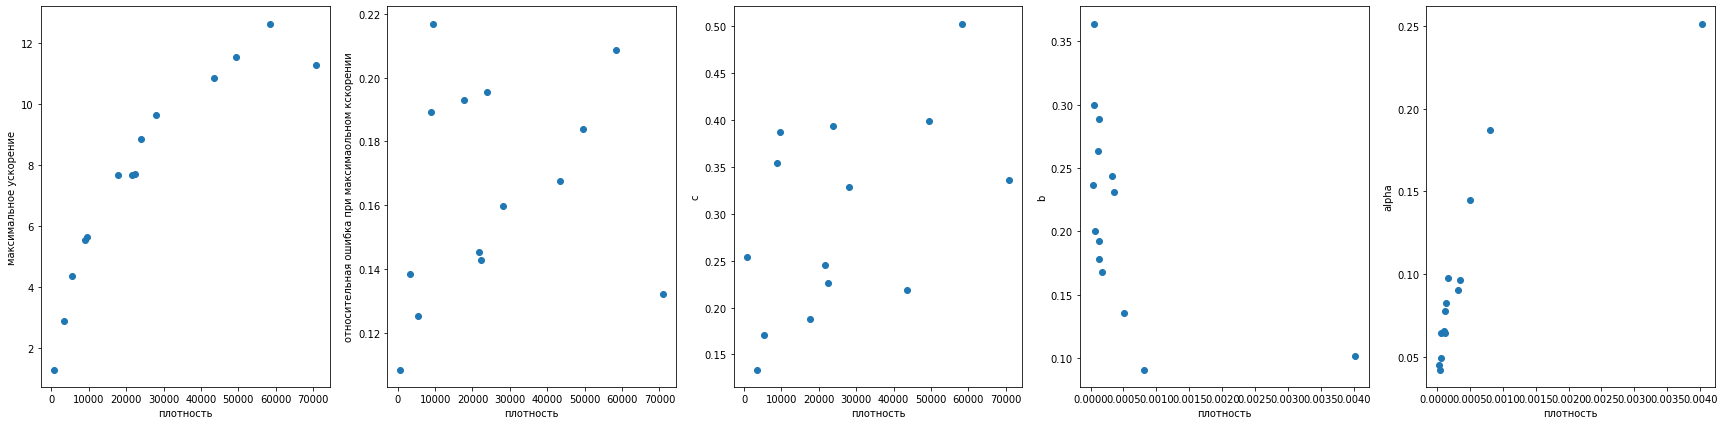

In [24]:
# X_max = {}
# Y_speedup_max = {}
# Y_err_speedup = {}

def t_f(x, N, b):
    return

fig, axs = plt.subplots(1, 5)
fig.set_figwidth(30)
fig.set_figheight(7)


X_betta = [city_to_n[name] for name in city_to_n]
Y_betta_speedup =[Y_speedup_max[n] for n in Y_speedup_max]
Y_betta_err =[Y_err_speedup[n] for n in Y_err_speedup]

Y_c = [c[name] for name in c]
Y_b = [b[name] for name in b]

axs[0].errorbar(X_betta, Y_betta_speedup, fmt='o')
axs[0].set(xlabel='плотность', ylabel='максимальное ускорение')


axs[1].errorbar(X_betta, Y_betta_err, fmt='o')
axs[1].set(xlabel='плотность', ylabel='относительная ошибка при максимаольном кскорении')



axs[2].errorbar(X_betta, Y_c, fmt='o')
axs[2].set(xlabel='плотность', ylabel='c')
X_betta = [r[n].density for n in r]

axs[3].errorbar(X_betta, Y_b, fmt='o')
axs[3].set(xlabel='плотность', ylabel='b')


axs[4].errorbar(X_betta, [X_max[name] for name in X_max], fmt='o')
axs[4].set(xlabel='плотность', ylabel='alpha')

plt.show()

In [8]:
def line(x, a,b):
    return a*x + b

def line_predict(x, a,b,alpha, N):
    # print("a:{:.2f} n:{:.2f}".format(alpha, N))
    return a*x/(alpha * (1 + np.log(alpha)/np.log(N))) + b

def inverse(x,a,b,c):
    return a*(x**c) + b

Уберем последние 4 точки

C:\Users\Dmitry\AppData\Local\Temp\ipykernel_57968\170412979.py:9: RuntimeWarning: overflow encountered in power
  return a*(x**c) + b


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

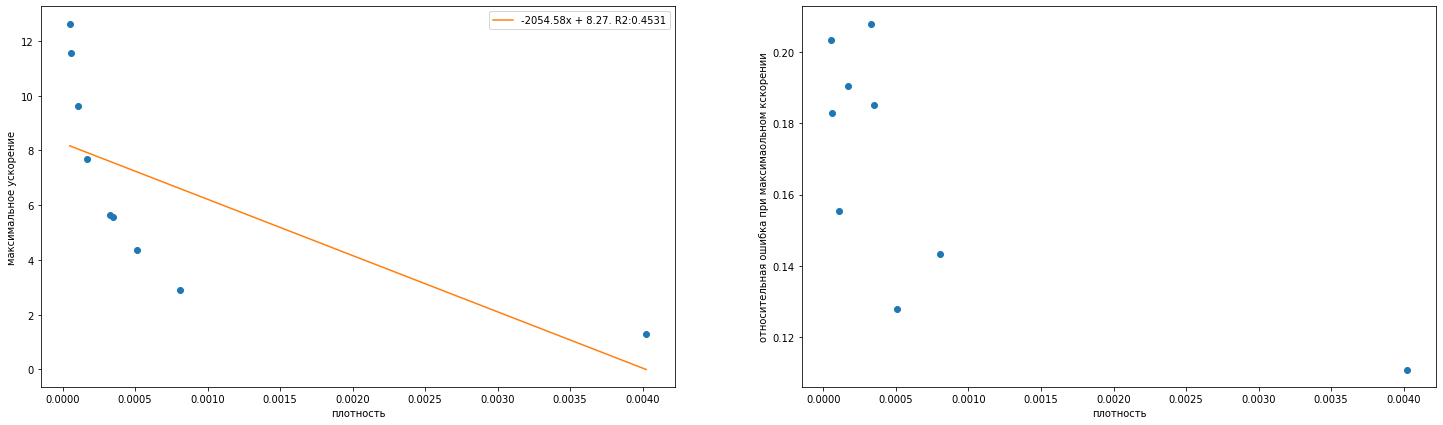

In [9]:
# X_max = {}
# Y_speedup_max = {}
# Y_err_speedup = {}

fig, axs = plt.subplots(1, 2)
fig.set_figwidth(25)
fig.set_figheight(7)

X_max_1 = dict(list(X_max.items())[0:-5])
X_betta = [r[n].density for n in r][0:-5]
Y_betta_speedup =[Y_speedup_max[n] for n in Y_speedup_max][0:-5]
Y_betta_err =[Y_err_speedup[n] for n in Y_err_speedup][0:-5]

axs[0].errorbar(X_betta, Y_betta_speedup, fmt='o')
axs[0].set(xlabel='плотность', ylabel='максимальное ускорение')
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(X_betta,Y_betta_speedup)

_x = np.linspace(min(X_betta), max(X_betta))
_y = slope * _x + intercept
axs[0].errorbar(_x, _y,label = '{:.2f}x + {:.2f}. R2:{:.4f}'.format(slope,intercept, r_value**2))
axs[0].legend()


# _x = X_betta
# f = partial(line_predict, N = [r[name].nodes for name in r][0])
# _y = []
# for i,a in enumerate(X_max_1):
#     _y.append(f(_x[i], slope/15, intercept, X_max_1[a]))
#
# axs[0].errorbar(_x, _y, fmt = 'o')
# axs[0].legend()



axs[1].errorbar(X_betta, Y_betta_err, fmt='o')
axs[1].set(xlabel='плотность', ylabel='относительная ошибка при максимаольном кскорении')

popt = curve_fit(inverse, X_betta, Y_betta_err, p0=[0.000000015, -1.5,0.06])
_xx = np.linspace(min(X_betta), max(X_betta), 300)
_yy = inverse(_xx, *popt[0])
axs[1].errorbar(_xx, _yy,label = '{:.10f}x^(-2) + {:.4f}'.format(popt[0][0],popt[0][1]))
axs[1].legend()
plt.show()

In [ ]:
from graph_generator import get_graph

H = get_graph('R2555133')


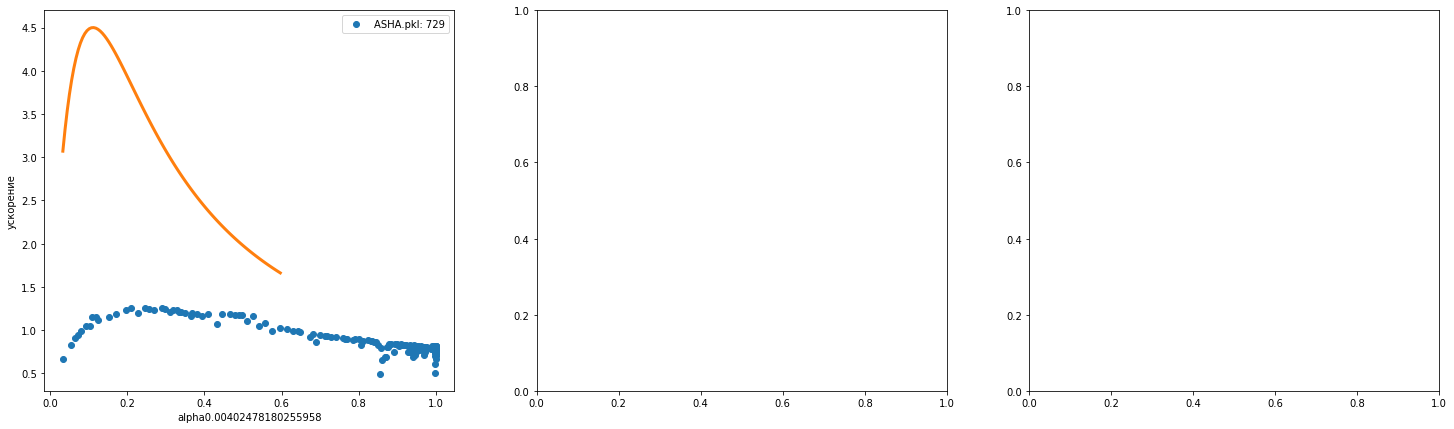

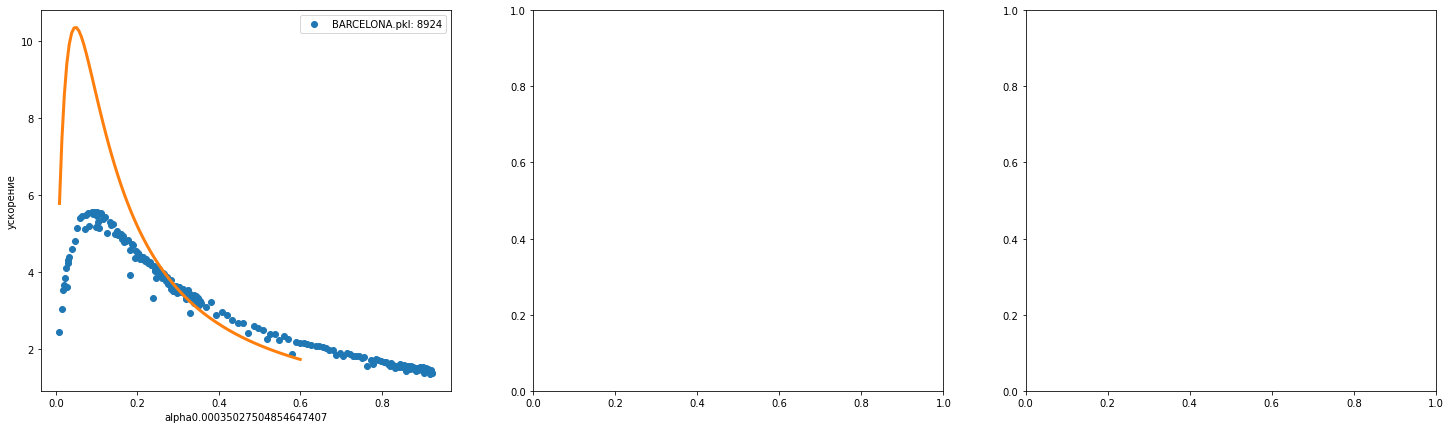

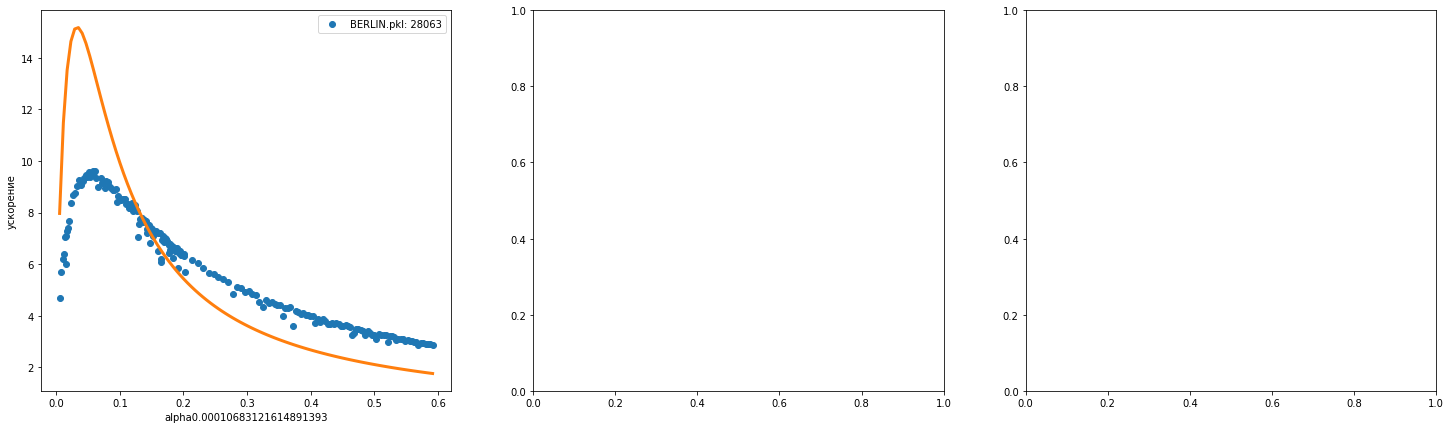

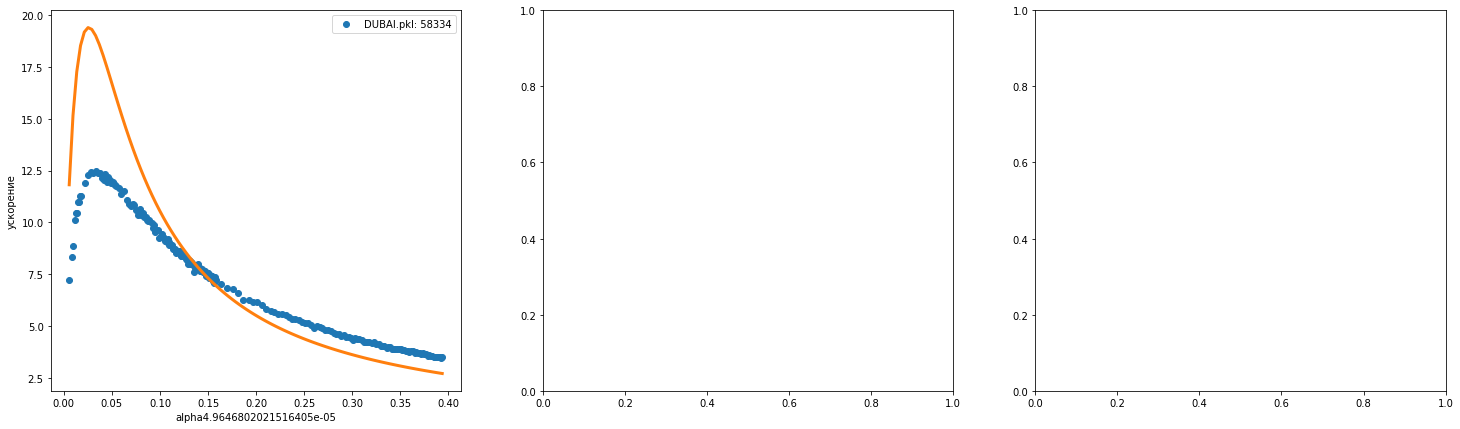

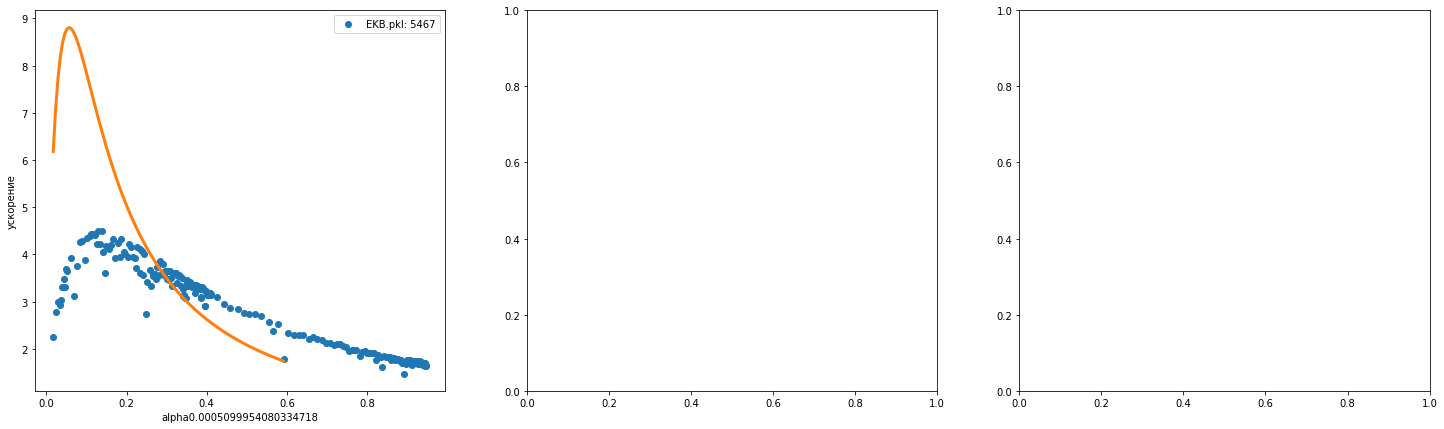

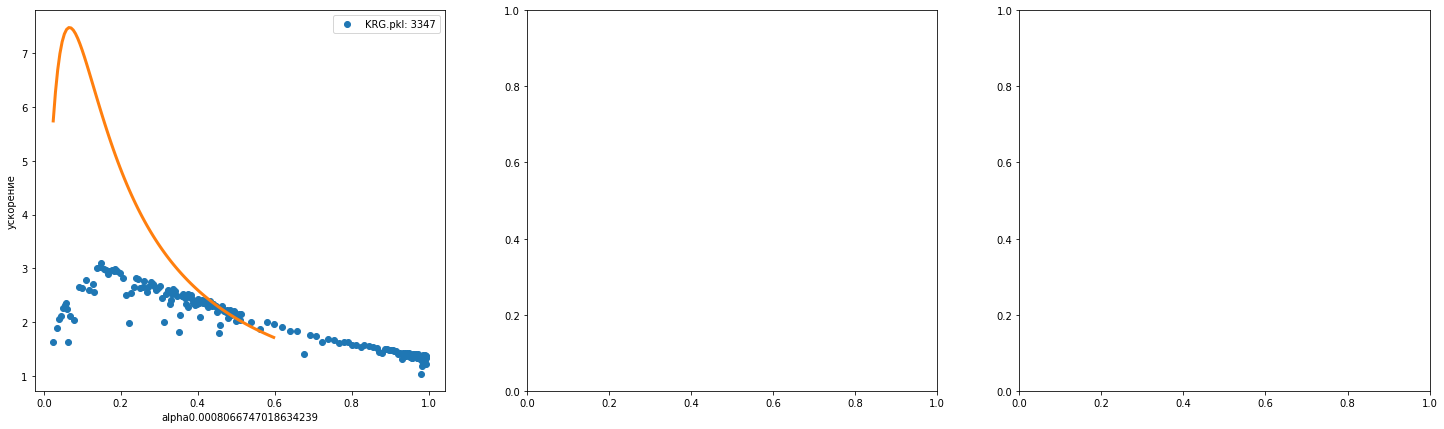

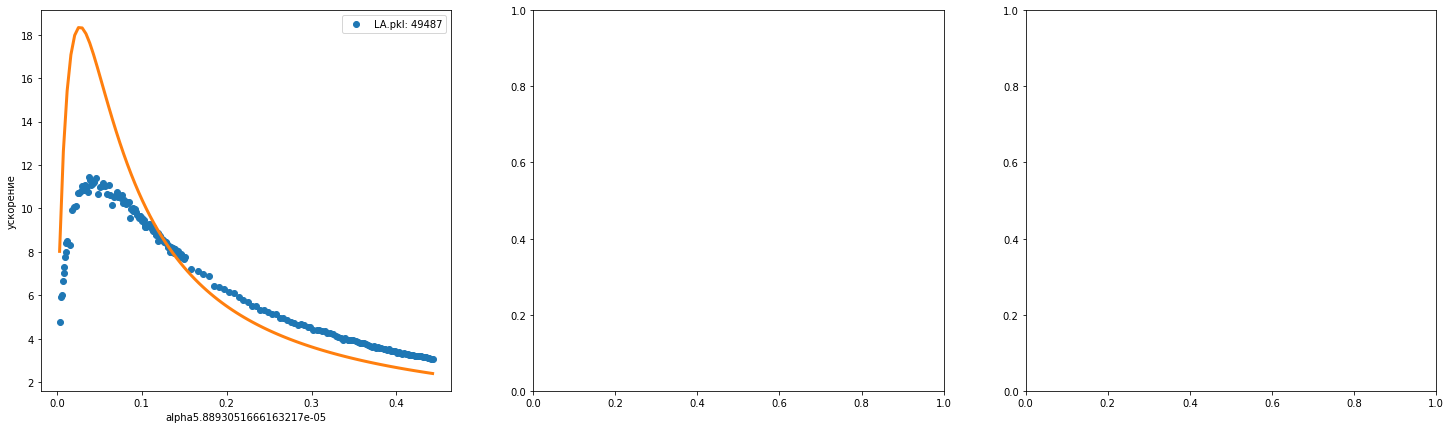

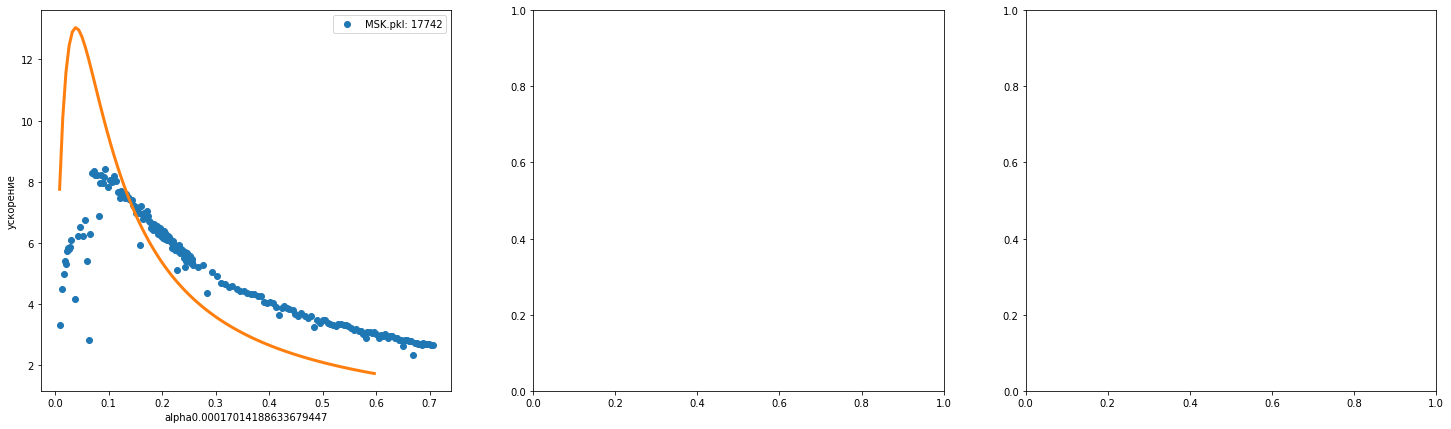

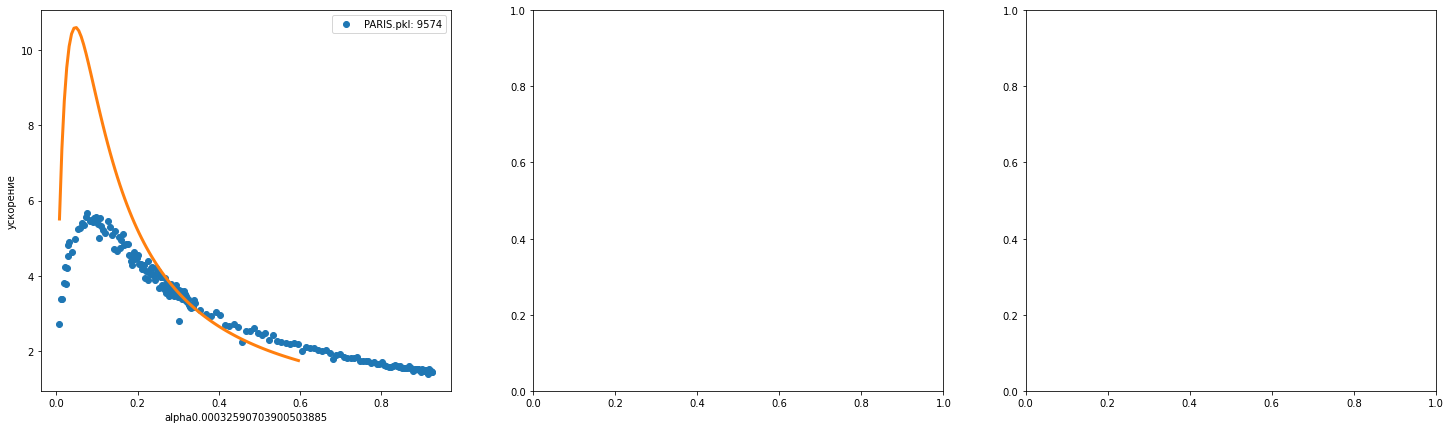

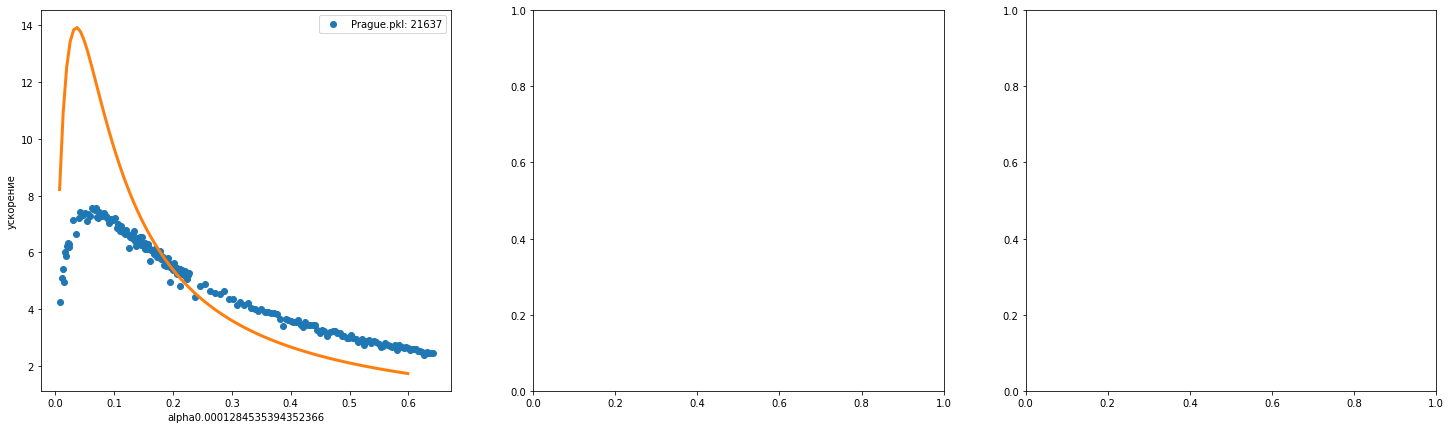

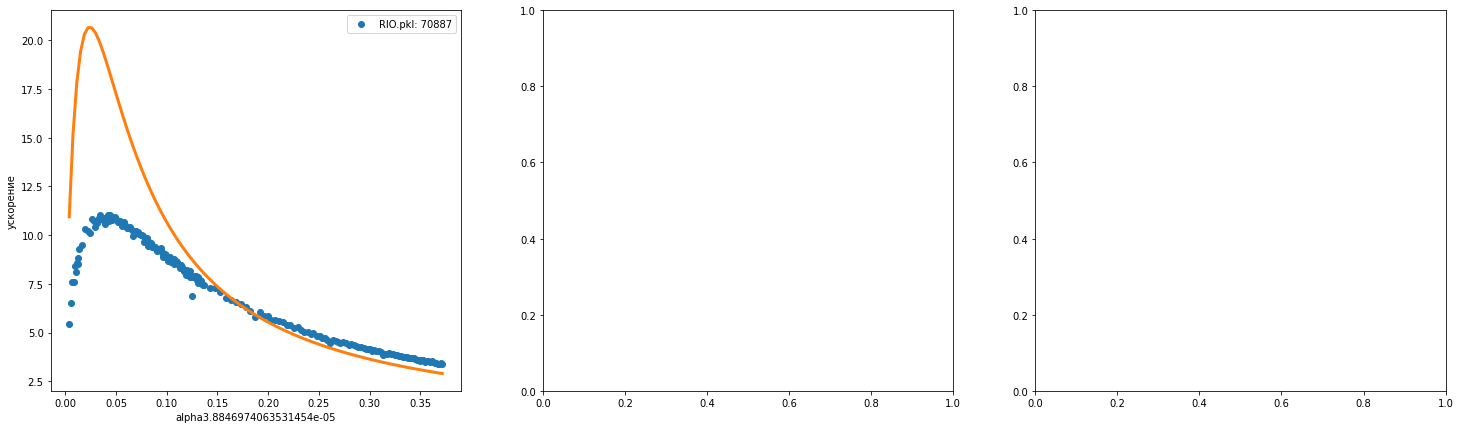

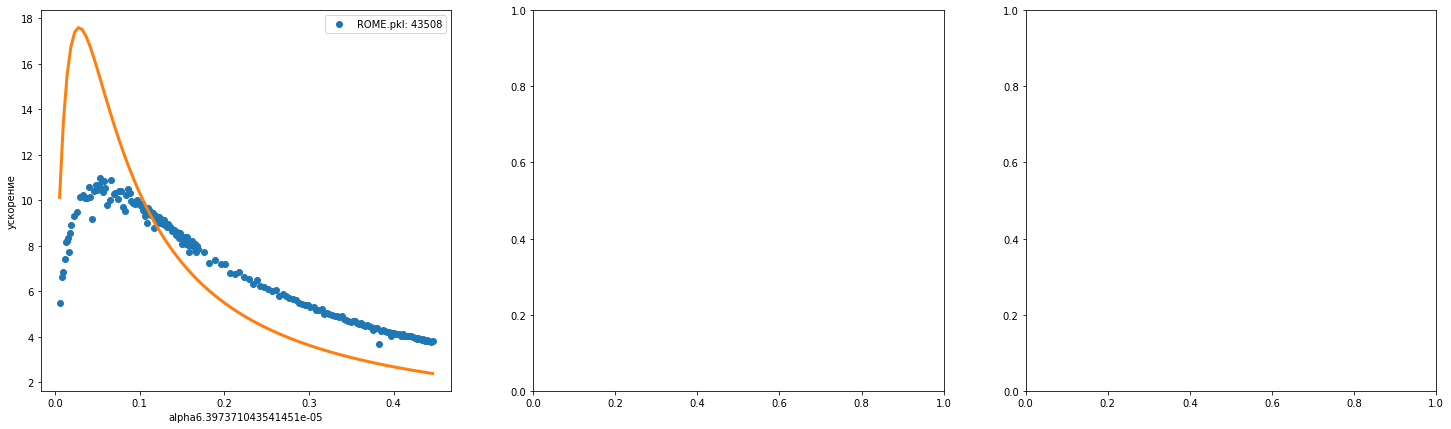

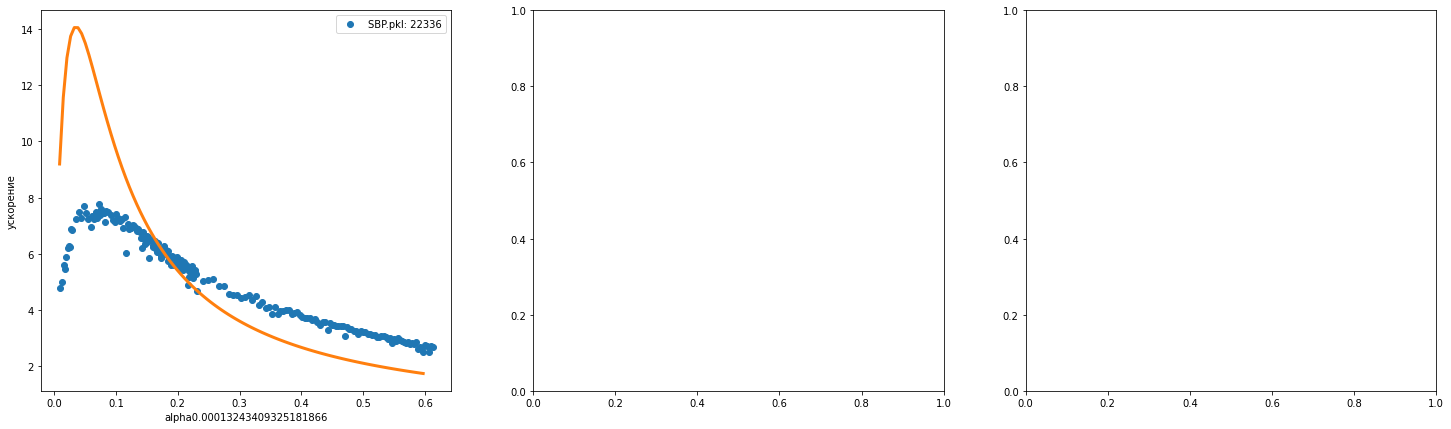

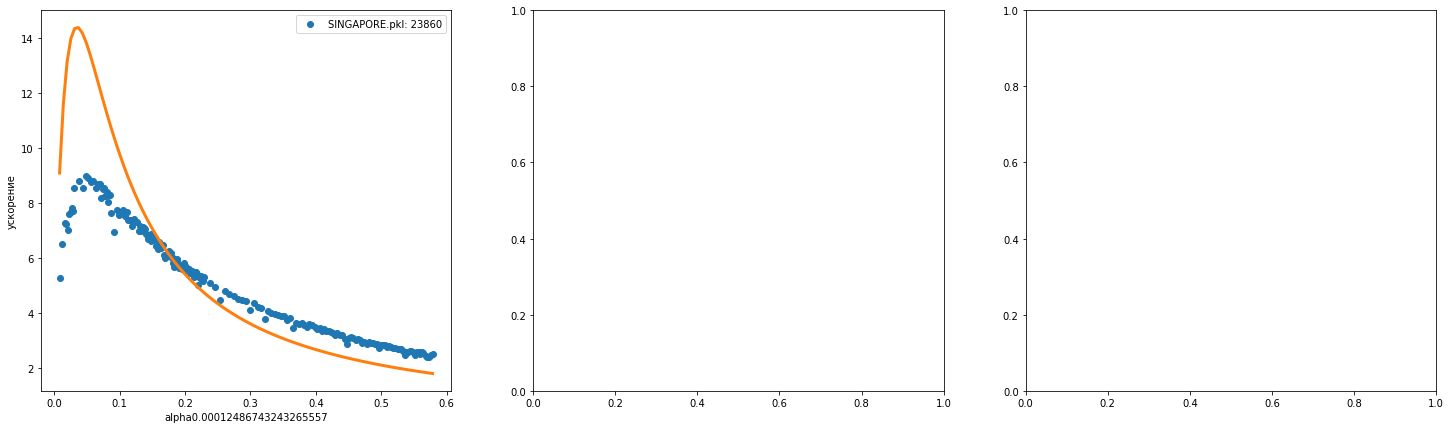

In [20]:
def _f(x, N):
    q = np.log(x) / np.log(N)
    return 1 / (x * (1 + q) + 1 / (np.sqrt(x * N)) * (1 - q))

for name in r:
    fig, axs = plt.subplots(1, 3)
    fig.set_figwidth(25)
    fig.set_figheight(7)

    axs[0].errorbar(X_a[name], Y_speedup[name], fmt='o', label = "{}: {}".format(name, r[name].nodes))
    axs[0].set(xlabel='alpha'+ str(r[name].density), ylabel='ускорение')

    # func_r = partial(theory_func, N=r[name].nodes, b0=r[name].edges/r[name].nodes)
    # print(str(r[name].nodes) + ' ' + str(r[name].edges/r[name].nodes))
    # print(str(r[name].nodes) + ' ' + str(2*r[name].edges/(r[name].nodes * (r[name].nodes-1))))

    _x = np.array(X_a[name])
    _x = _x[_x < 0.6]
    _xx = np.linspace(min(_x), max(_x), 100)

    func_target = partial(_f, N=r[name].nodes)
    _y = func_target(np.array(_xx))
    axs[0].errorbar(_xx, _y, linewidth=3)
    axs[0].legend()
    # axs[1].errorbar(X_a[name], Y_err[name], fmt='o')
    # axs[1].set(xlabel='alpha' + str(r[name].density), ylabel='средняя относительная ошибка')
    # z = np.polyfit(X_a[name], Y_err[name], 6)
    # p = np.poly1d(z)
    # axs[1].errorbar(_xx, p(_xx), fmt='o')
    # Y_err_speedup[name] = p(a)
    #
    #
    #
    # axs[2].errorbar(X_a[name], Y_err_std[name], fmt='o')
    # axs[2].set(xlabel='alpha'+ str(r[name].density), ylabel='погрешность ошибки')

    # file_name = generate_new_name(name + '.png', 'plots')

    # plt.savefig(file_name)

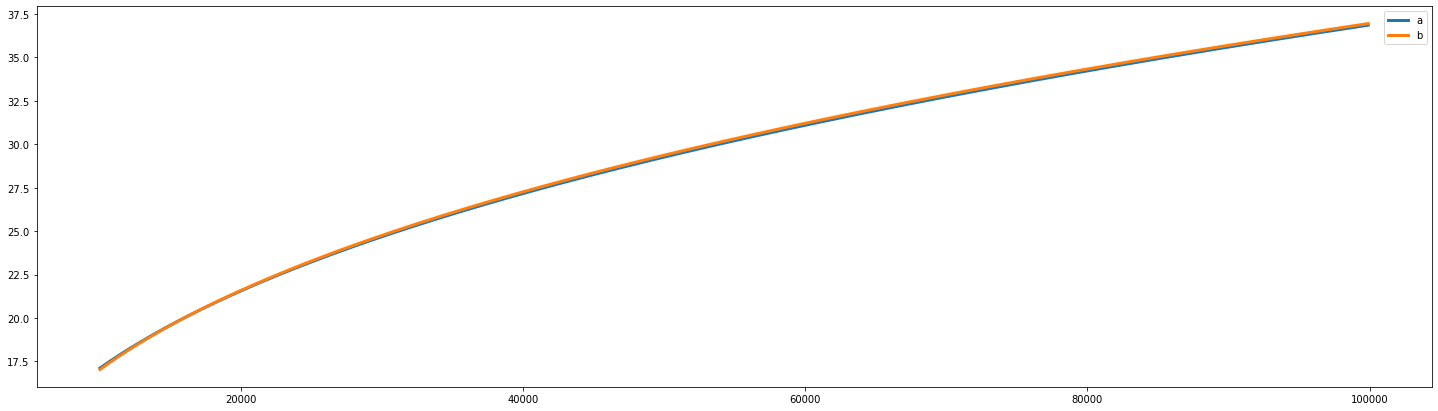

In [77]:
def _f(x, N):
    q = np.log(x) / np.log(N)
    return 1 / (x * (1 + q) + 1 / (2*np.sqrt(x * N)) * (1 - q))

arr_N = [i for i in range(10000, 100000,100)]
y = []
for i in arr_N:
    func_target = partial(_f, N=i)
    a = scipy.optimize.fminbound(lambda x: -func_target(x), 0, 1)
    y.append(func_target(a))

fig, axs = plt.subplots(1, 1)
fig.set_figwidth(25)
fig.set_figheight(7)

axs.errorbar(arr_N, y, linewidth=3,label='a')
axs.errorbar(arr_N, (np.array(arr_N)) ** 0.317 -1.5, linewidth=3, label = 'b')
axs.legend()
